In [ ]:
!pip install deepee

In [ ]:
from deepee import (PrivacyWrapper, PrivacyWatchdog, UniformDataLoader,
                     ModelSurgeon, SurgicalProcedures)
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import cv2
from torchvision.transforms import functional as F

class args:
    batch_size = 200
    test_batch_size = 200
    log_interval = 1000
    num_epochs = 5
    device = "cuda" if torch.cuda.is_available() else "cpu"
device = args.device

In [ ]:
train_loader = UniformDataLoader(
    
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256, track_running_stats=False)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = self.bn1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
import os
from tensorflow.keras.models import model_from_json

if not os.path.exists('./trained_models'):
    os.makedirs('./trained_models')

if not os.path.exists('./trained_models/dncnn.json'):
    os.system('wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/models/DnCNN_sigma25/model.json -O ./trained_models/dncnn.json')

if not os.path.exists('./trained_models/dncnn.h5'):
    os.system('wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/models/DnCNN_sigma25/model.h5 -O ./trained_models/dncnn.h5')
    
json_file = open('trained_models/dncnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights('./trained_models/dncnn.h5')

print(model.summary())

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299666


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 0.5820, Accuracy: 8485/10000 (85%)


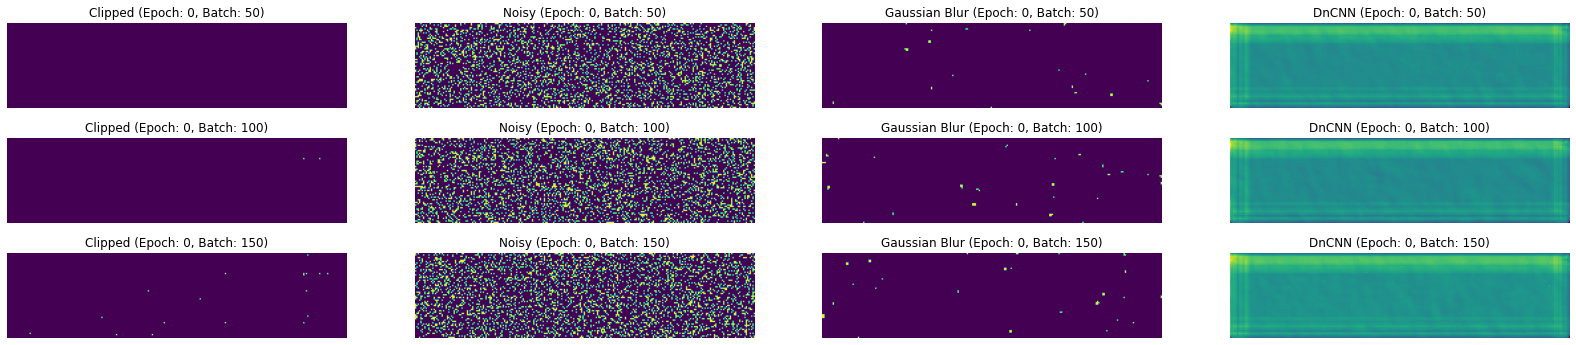

In [ ]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

rows = 3
columns = 4
i = 1
fig = plt.figure(figsize=(columns*7, rows*2))

# Train
for epoch in range(1):#(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 0 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            fig.add_subplot(rows, columns, i)
            plt.imshow(F.to_pil_image(model.wrapped_model.fc2.weight.grad))
            plt.axis('off')
            plt.title("Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")
        
            model.noise_gradient()
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(F.to_pil_image(model.wrapped_model.fc2.weight.grad))
            plt.axis('off')
            plt.title("Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")

            fig.add_subplot(rows, columns, i+2)
            plt.imshow(F.to_pil_image(torch.tensor(
                cv2.GaussianBlur(np.array(model.wrapped_model.fc2.weight.grad), (5,5), 0))))
            plt.axis('off')
            plt.title("Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")

            fig.add_subplot(rows, columns, i+3)
            plt.imshow(from_tf(dncnn.predict(to_tf(np.array(model.wrapped_model.fc2.weight.grad)))))
            plt.axis('off')
            plt.title("DnCNN (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")
            
            i = i+4
        else:
            model.clip_and_accumulate()
            model.noise_gradient()

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [24]:
dncnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 640         input0[0][0]                     
__________________________________________________________________________________________________
relu2 (Activation)              (None, None, None, 6 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, None, None, 6 36864       relu2[0][0]                      
____________________________________________________________________________________________